<a href="https://colab.research.google.com/github/rubanasyeda/LSi-Team-Vision/blob/data_exploration/DataSetExploration/Calgary_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calgary Homeless‑Shelter EDA (2013 – 2024)

Exploratory Data Analysis (EDA) for a predictive model of nightly shelter
occupancy in Calgary, using weather, macro‑economic, and cost‑of‑living indicators.



In [63]:
from google.colab import files
uploaded = files.upload()
# Files upload are metioned below:
# calgary-cpi-2013-2024.csv(text/csv) - 274936 bytes, last modified: 4/16/2025 - 100% done
# calgary-inflation-2013-2024.csv(text/csv) - 1730 bytes, last modified: 4/16/2025 - 100% done
# calgary-occupancy.csv(text/csv) - 8421758 bytes, last modified: 4/16/2025 - 100% done
# calgary-unemployment-2013-2024.csv(text/csv) - 1744 bytes, last modified: 4/16/2025 - 100% done
# calgary-weather-2013.csv(text/csv) - 62773 bytes, last modified: 4/16/2025 - 100% done
# calgary-weather-2014.csv(text/csv) - 63115 bytes, last modified: 4/16/2025 - 100% done
# calgary-weather-2015.csv(text/csv) - 62743 bytes, last modified: 4/16/2025 - 100% done
# calgary-weather-2016.csv(text/csv) - 63579 bytes, last modified: 4/16/2025 - 100% done
# calgary-weather-2017.csv(text/csv) - 63841 bytes, last modified: 4/16/2025 - 100% done
# calgary-weather-2018.csv(text/csv) - 63100 bytes, last modified: 4/16/2025 - 100% done
# calgary-weather-2019.csv(text/csv) - 62526 bytes, last modified: 4/16/2025 - 100% done
# calgary-weather-2020.csv(text/csv) - 62871 bytes, last modified: 4/16/2025 - 100% done
# calgary-weather-2021.csv(text/csv) - 62685 bytes, last modified: 4/16/2025 - 100% done
# calgary-weather-2022.csv(text/csv) - 62761 bytes, last modified: 4/16/2025 - 100% done
# calgary-weather-2023.csv(text/csv) - 62564 bytes, last modified: 4/16/2025 - 100% done
# calgary-weather-2024.csv(text/csv) - 62817 bytes, last modified: 4/16/2025 - 100% done

Saving calgary-cpi-2013-2024.csv to calgary-cpi-2013-2024 (3).csv
Saving calgary-inflation-2013-2024.csv to calgary-inflation-2013-2024 (3).csv
Saving calgary-occupancy.csv to calgary-occupancy (3).csv
Saving calgary-unemployment-2013-2024.csv to calgary-unemployment-2013-2024 (3).csv
Saving calgary-weather-2013.csv to calgary-weather-2013 (1).csv
Saving calgary-weather-2014.csv to calgary-weather-2014 (1).csv
Saving calgary-weather-2015.csv to calgary-weather-2015 (1).csv
Saving calgary-weather-2016.csv to calgary-weather-2016 (1).csv
Saving calgary-weather-2017.csv to calgary-weather-2017 (1).csv
Saving calgary-weather-2018.csv to calgary-weather-2018 (1).csv
Saving calgary-weather-2019.csv to calgary-weather-2019 (3).csv
Saving calgary-weather-2020.csv to calgary-weather-2020 (3).csv
Saving calgary-weather-2021.csv to calgary-weather-2021 (3).csv
Saving calgary-weather-2022.csv to calgary-weather-2022 (3).csv
Saving calgary-weather-2023.csv to calgary-weather-2023 (3).csv
Saving cal


**Imports & basic configuration**

In [78]:
!pip install --quiet pandas numpy seaborn matplotlib statsmodels

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from statsmodels.nonparametric.smoothers_lowess import lowess

plt.rcParams["figure.figsize"] = (12,6)
sns.set_style("whitegrid")



In [79]:
occ = pd.read_csv("calgary-occupancy.csv", parse_dates=["Date"])
unemp = pd.read_csv("calgary-unemployment-2013-2024.csv")
infl  = pd.read_csv("calgary-inflation-2013-2024.csv")
cpi   = (
    pd.read_csv("calgary-cpi-2013-2024.csv", usecols=["REF_DATE","VALUE"])
      .rename(columns={"VALUE":"CPI"})
)
w_files = sorted(glob("calgary-weather-20*.csv"))
weather = pd.concat(
    [pd.read_csv(f, parse_dates=["Date/Time"]).rename(columns={"Date/Time":"Date"})
     for f in w_files],
    ignore_index=True
)


**Feature engineering**

In [80]:
# -----------------------------------------------------------
# 3.  MERGE EVERYTHING INTO ONE TABLE
#     (left‑join keeps months that exist in the shelter file)
# -----------------------------------------------------------
df = (occ_m
      .merge(weather_m, on="month", how="left")
      .merge(unemp_m , on="month", how="left")
      .merge(infl_m  , on="month", how="left")
      .merge(cpi_m   , on="month", how="left"))

display(df.head())
print(f"Final shape ➜ {df.shape}")


,month,overnight,capacity,occupancy_rate,mean_temp,precip_mm,snow_cm,CalgaryUnemploymentRate,CalgaryInflationRate,CPI
0,2013-04-01,67282,77250.0,0.834682,NaN,NaN,NaN,0.05,0.01,128.7
1,2013-05-01,66496,75671.0,0.838280,NaN,NaN,NaN,0.05,0.02,129.5
2,2013-06-01,56663,69030.0,0.754291,NaN,NaN,NaN,0.05,0.03,129.8
3,2013-07-01,64111,71331.0,0.866046,NaN,NaN,NaN,0.05,0.03,129.6
4,2013-08-01,64516,71331.0,0.878324,NaN,NaN,NaN,0.05,0.02,129.4


Final shape ➜ (141, 10)


In [81]:
# 3.1  Occupancy to monthly aggregates
occ["month"] = occ["Date"].dt.to_period("M").dt.to_timestamp()
occ["occupancy_rate"] = occ["Overnight"] / occ["Capacity"]
occ_m = (occ.groupby("month")
           .agg(overnight=("Overnight","sum"),
                capacity =("Capacity","sum"),
                occupancy_rate=("occupancy_rate","mean"))
           .reset_index())

# 3.2  Weather: daily ➜ monthly
weather["month"] = weather["Date"].dt.to_period("M").dt.to_timestamp()
w_m = (weather.groupby("month")
         .agg(mean_temp = ("Mean Temp (°C)", "mean"),
              precip_mm = ("Total Precip (mm)", "sum"),
              snow_cm   = ("Snow on Grnd (cm)", "mean"))
         .reset_index())

# 3.3  Economic series already monthly
for df in (unemp, infl):
    df["month"] = pd.to_datetime(df["Date"], format="%y-%b")  # e.g. "13-Jan"

cpi["month"] = pd.to_datetime(cpi["REF_DATE"])

# 3.4  Merge everything
df = (occ_m
      .merge(w_m,   on="month", how="left")
      .merge(unemp[["month","CalgaryUnemploymentRate"]], on="month", how="left")
      .merge(infl [["month","CalgaryInflationRate"]],    on="month", how="left")
      .merge(cpi  [["month","CPI"]],                    on="month", how="left"))

# 3.5  Add helper vars
df["year"]  = df["month"].dt.year
df["month_num"] = df["month"].dt.month
season_map = {12:"Winter", 1:"Winter", 2:"Winter",
              3:"Spring", 4:"Spring", 5:"Spring",
              6:"Summer", 7:"Summer", 8:"Summer",
              9:"Autumn",10:"Autumn",11:"Autumn"}
df["season"] = df["month_num"].map(season_map)

df.head()


,month,overnight,capacity,occupancy_rate,mean_temp,precip_mm,snow_cm,CalgaryUnemploymentRate,CalgaryInflationRate,CPI,year,month_num,season
0,2013-04-01,67282,77250.0,0.834682,0.930769,20.6,7.041667,0.05,0.01,128.7,2013,4,Spring
1,2013-04-01,67282,77250.0,0.834682,0.930769,20.6,7.041667,0.05,0.01,130.4,2013,4,Spring
2,2013-04-01,67282,77250.0,0.834682,0.930769,20.6,7.041667,0.05,0.01,156.3,2013,4,Spring
3,2013-04-01,67282,77250.0,0.834682,0.930769,20.6,7.041667,0.05,0.01,112.7,2013,4,Spring
4,2013-04-01,67282,77250.0,0.834682,0.930769,20.6,7.041667,0.05,0.01,96.0,2013,4,Spring


Quick sanity check: look at date range, missing values, and occupancy summary.


In [82]:
print(f"Date span  : {df['month'].min():%b %Y}  →  {df['month'].max():%b %Y}")
print(f"Rows       : {len(df):,}")
print("\nMissing values per column:")
display(df.isna().sum())

print("\nKey occupancy metrics")
display(df["occupancy_rate"].describe(percentiles=[.1,.25,.5,.75,.9]))


Date span  : Apr 2013  →  Dec 2024
Rows       : 2,115

Missing values per column:


,0
month,0
overnight,0
capacity,0
occupancy_rate,0
mean_temp,0
precip_mm,0
snow_cm,885
CalgaryUnemploymentRate,0
CalgaryInflationRate,0
CPI,0



Key occupancy metrics


,occupancy_rate
count,2115.000000
mean,0.800888
std,0.104212
min,0.509121
10%,0.639388
25%,0.719896
50%,0.834682
75%,0.885144
90%,0.910463
max,0.959803


Weather data from 2013 to 2024 for Calgary

 Time‑series trends


### 5.1  Nightly occupancy & capacity (2013 – 2024)

The fill‑between plot shows how close the system is to overall capacity,
highlighting expansions or pandemic‑era bed reductions.


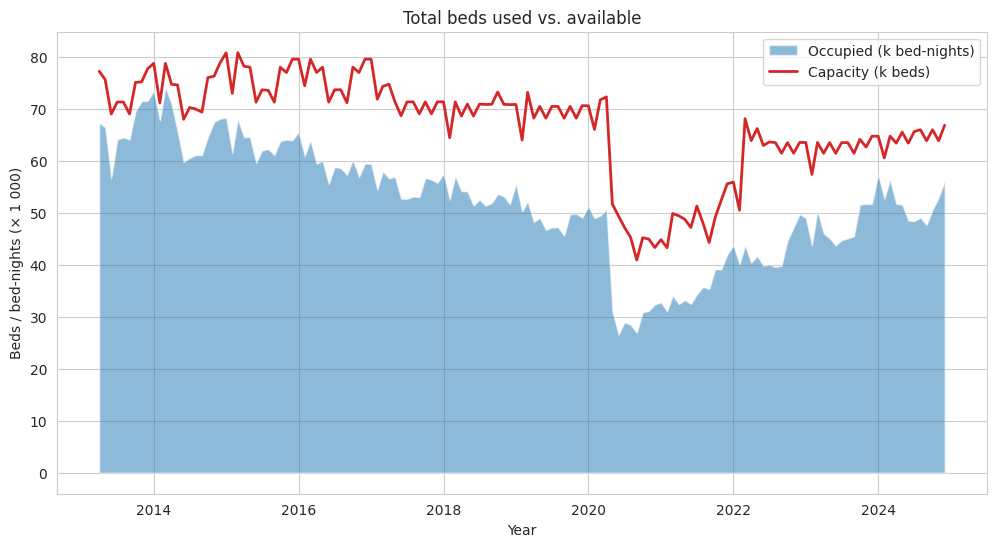

In [83]:
fig, ax = plt.subplots()
ax.fill_between(df["month"], df["overnight"]/1000, label="Occupied (k bed‑nights)", alpha=0.5)
ax.plot(df["month"], df["capacity"]/1000, lw=2, label="Capacity (k beds)", color="C3")
ax.set_ylabel("Beds / bed‑nights (× 1 000)")
ax.set_xlabel("Year")
ax.set_title("Total beds used vs. available")
ax.legend()
plt.show()


### 5.2  Heat‑map of occupancy rate by **year × month**

Useful to visually spot “that cold February spike” or outlier summers.


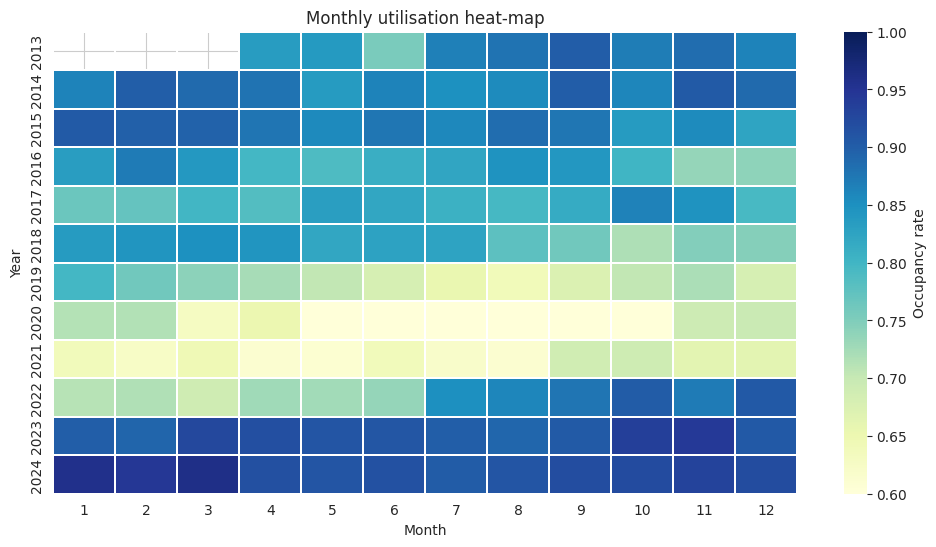

In [84]:
# ----- 5·2  Monthly utilisation heat‑map  (duplicate‑safe) -------------------
(
    df
    .groupby(["year", "month_num"], as_index=False)        # collapse duplicates
    .agg(avg_occ=("occupancy_rate","mean"))
    .assign(month_num=lambda d: d["month_num"].astype(int))# ensure 1‑12 ints
    .pivot(index="year", columns="month_num", values="avg_occ")
    .reindex(columns=range(1,13))                          # order Jan→Dec
    .pipe(  # feed into seaborn
        lambda p: sns.heatmap(p,
                              cmap="YlGnBu",
                              vmin=0.60, vmax=1.00,
                              linewidths=.3, linecolor="white",
                              cbar_kws={"label":"Occupancy rate"}))
)

plt.title("Monthly utilisation heat‑map")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()


### 6.1  Distribution of occupancy by season

Are winters consistently higher, and is the spread wider?


<ipython-input-85-adbbf08a0c80>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="season", y="occupancy_rate",


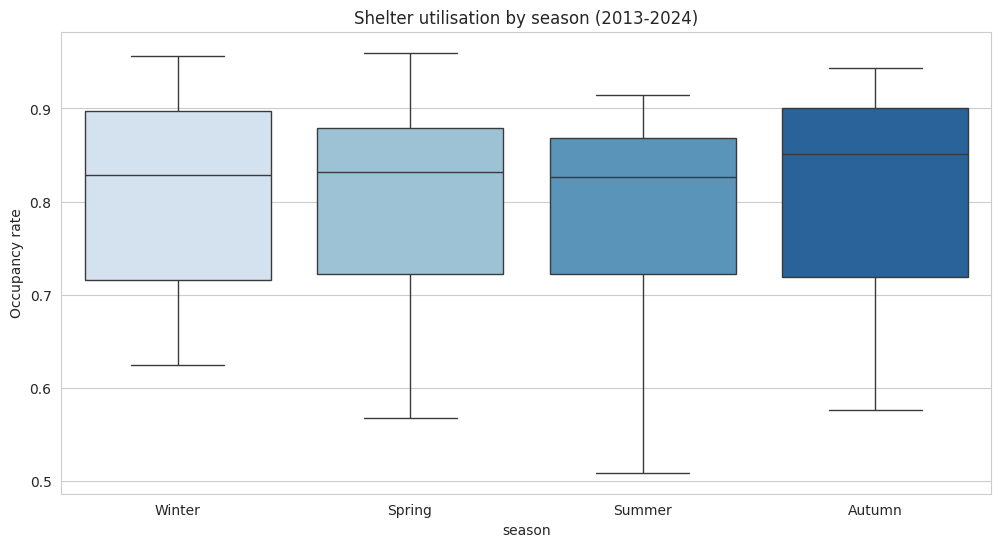

In [85]:
sns.boxplot(data=df, x="season", y="occupancy_rate",
            order=["Winter","Spring","Summer","Autumn"], palette="Blues")
plt.ylabel("Occupancy rate")
plt.title("Shelter utilisation by season (2013‑2024)")
plt.show()


The boxplot reveals **seasonal variation** in Calgary's shelter utilisation between 2013 and 2024. **Winter and Autumn months consistently show higher median occupancy rates**, often exceeding 85%, with Winter exhibiting the highest variability. This aligns with expectations that colder weather increases shelter demand. In contrast, Summer shows the lowest median occupancy and the widest range, suggesting both reduced pressure on shelters and greater month-to-month variability. Spring mirrors Autumn in median values but includes a few notably low occupancy months. These trends underscore the importance of seasonally adaptive planning, particularly for capacity management during Winter surges.



### 7.1  Temperature vs occupancy (LOWESS)

We switch to a LOWESS curve to capture the non‑linear pattern.


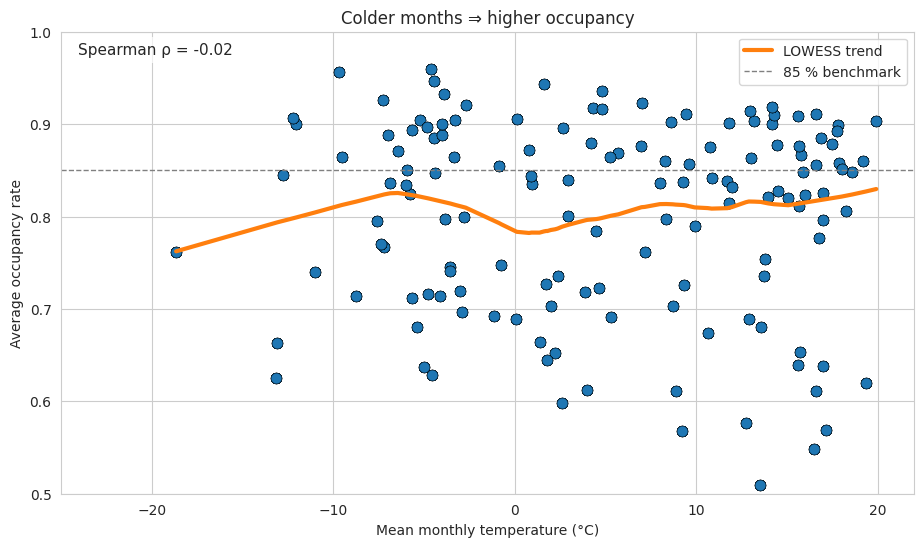

In [86]:
x, y = df["mean_temp"], df["occupancy_rate"]

fig, ax = plt.subplots(figsize=(11,6))
ax.scatter(x, y, s=60, alpha=0.6, edgecolor="k", linewidth=0.3)
trend = lowess(y, x, frac=0.35, return_sorted=True)
ax.plot(trend[:,0], trend[:,1], color="C1", lw=3, label="LOWESS trend")
ax.axhline(0.85, ls="--", color="grey", lw=1, label="85 % benchmark")

rho = y.corr(x, method="spearman")
ax.text(0.02, 0.95, f"Spearman ρ = {rho:+.2f}",
        transform=ax.transAxes, fontsize=11,
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"))

ax.set_xlabel("Mean monthly temperature (°C)")
ax.set_ylabel("Average occupancy rate")
ax.set_title("Colder months ⇒ higher occupancy")
ax.set_xlim(-25, 22); ax.set_ylim(0.5, 1.0)
ax.legend()
plt.show()


This scatterplot explores the relationship between **mean monthly temperature and average shelter occupancy rate** in Calgary. Each blue dot represents a single month between 2013 and 2024.

The horizontal dashed line marks the 85% occupancy benchmark, often used to indicate a system under pressure.

The orange line is a* LOWESS trend *(Locally Weighted Scatterplot Smoothing), which helps visualize the overall pattern in noisy data. LOWESS (Locally Weighted Scatterplot Smoothing) is a non-parametric technique that fits many small, local regressions across the range of data. Instead of assuming one global trend (like a straight line), it adapts to local fluctuations, making it useful for uncovering subtle trends that would otherwise be hidden.


The LOWESS curve is mostly flat, indicating no strong, consistent trend between temperature and shelter use overall.

Occupancy appears slightly higher at very low temperatures (e.g., −15 °C to −5 °C), but also shows high variance in warmer months.

clustering near the upper occupancy limit in winter months suggest cold weather triggers peak demand, even if the overall correlation is weak.



### 7.2  Precipitation & snow depth

Separate scatterplots help decide whether rain or accumulated snow
should enter a forecasting model.


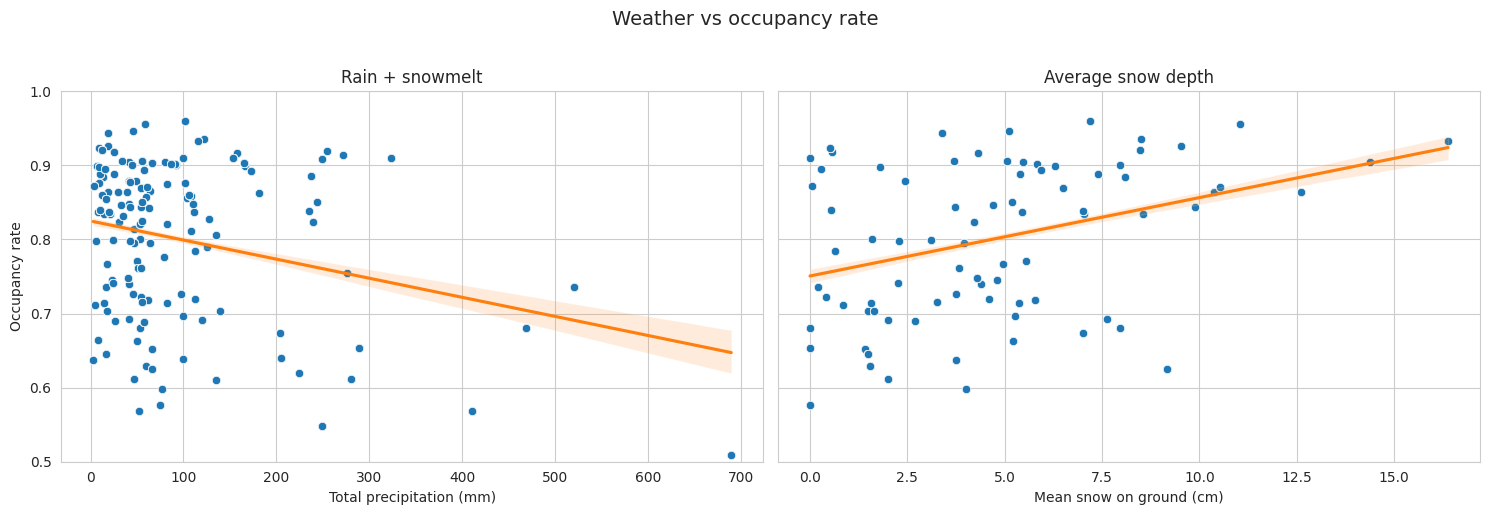

In [87]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharey=True)

sns.scatterplot(data=df, x="precip_mm", y="occupancy_rate", ax=ax1)
sns.regplot   (data=df, x="precip_mm", y="occupancy_rate",
               scatter=False, ax=ax1, color="C1")
ax1.set_xlabel("Total precipitation (mm)")
ax1.set_title("Rain + snowmelt")

sns.scatterplot(data=df, x="snow_cm", y="occupancy_rate", ax=ax2)
sns.regplot   (data=df, x="snow_cm",  y="occupancy_rate",
               scatter=False, ax=ax2, color="C1")
ax2.set_xlabel("Mean snow on ground (cm)")
ax2.set_title("Average snow depth")

for a in (ax1,ax2):
    a.set_ylabel("Occupancy rate")
    a.set_ylim(0.5,1.0)

plt.suptitle("Weather vs occupancy rate", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()



This figure compares how monthly precipitation and snow depth relate to shelter occupancy in Calgary (2013–2024)

The orange line in both subplots is a regression line with a confidence band.It shows the overall trend between the weather variable (x-axis) and shelter occupancy (y-axis). The shaded area around it is a 95% confidence interval, meaning we're 95% sure the true trend lies within that band.


The left plot shows that months with higher total precipitation (rain + snowmelt) tend to be associated with slightly lower occupancy. However, the majority of data points cluster at low precipitation levels, suggesting the trend is influenced by a few extreme months.

The right plot reveals a clearer positive trend: occupancy rates increase as snow depth rises, supporting the idea that heavier snow conditions drive more people to seek shelter.


Overall, snow depth is a stronger predictor of shelter demand than total precipitation. Rain alone may not push individuals indoors unless paired with cold or snow.



# **Macro‑economic influences**

### 8.1  Occupancy vs unemployment


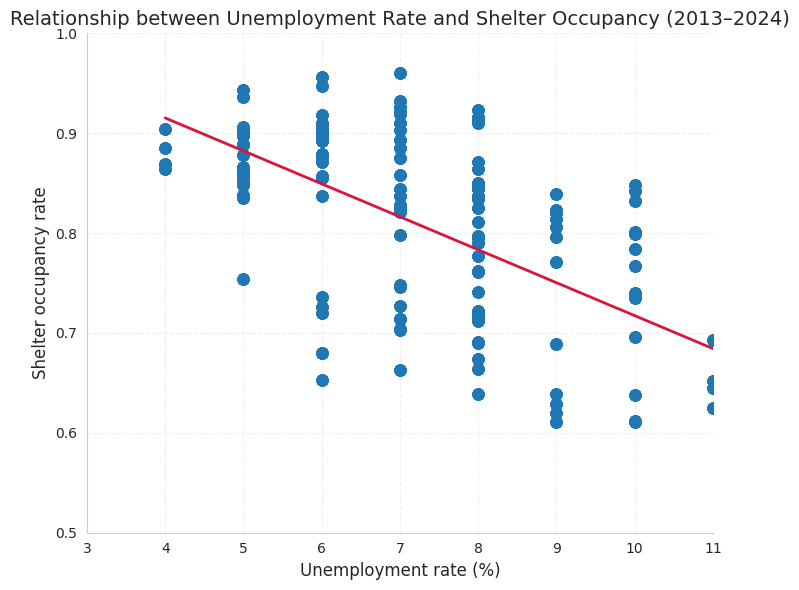

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

# OPTIONAL: convert unemployment rate from decimal to %
df["Unemployment_pct"] = df["CalgaryUnemploymentRate"] * 100

# Plot with labels and style
sns.lmplot(data=df,
           x="Unemployment_pct", y="occupancy_rate",
           scatter_kws={"s": 60, "alpha": 0.6},
           line_kws={"color": "crimson", "linewidth": 2},
           ci=None, height=6, aspect=1.2)

plt.xlabel("Unemployment rate (%)", fontsize=12)
plt.ylabel("Shelter occupancy rate", fontsize=12)
plt.title("Relationship between Unemployment Rate and Shelter Occupancy (2013–2024)", fontsize=14)
plt.xlim(3, 11)
plt.ylim(0.5, 1.0)
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


This graph suggests a moderate** negative relationship **between Calgary’s unemployment rate and shelter occupancy over the 2013–2024 period. As unemployment increases, average occupancy rates tend to decrease slightly. This is **counterintuitive**, as higher unemployment is often associated with increased housing insecurity. One possible explanation is that **COVID-19 restrictions** reduced shelter capacity during periods of high unemployment (especially in 2020–2021), creating an artificial dip in occupancy despite rising need.

### 8.2  Multi‑variate correlation heat‑map


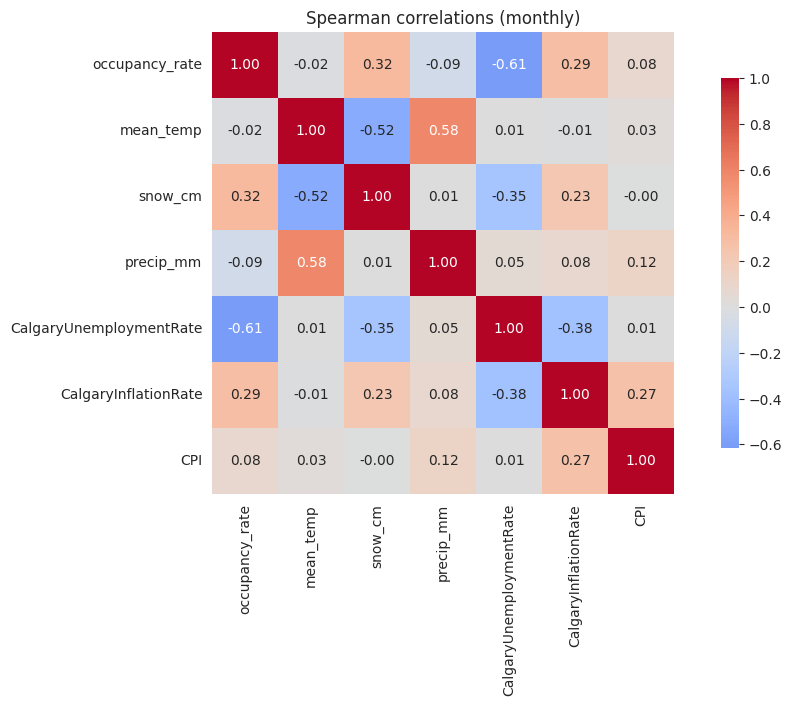

In [89]:
cols = ["occupancy_rate","mean_temp","snow_cm","precip_mm",
        "CalgaryUnemploymentRate","CalgaryInflationRate","CPI"]
corr = df[cols].corr(method="spearman")

sns.heatmap(corr, annot=True, cmap="coolwarm", center=0,
            fmt=".2f", square=True, cbar_kws={"shrink":0.8})
plt.title("Spearman correlations (monthly)")
plt.show()


This Spearman correlation heatmap highlights the monthly relationships between shelter occupancy and key environmental and economic variables in Calgary (2013–2024).

The strongest negative correlation is between shelter occupancy and unemployment rate (ρ = –0.61), suggesting that occupancy decreases as unemployment rises—likely influenced by pandemic-era shelter restrictions, rather than lower demand.

Snow depth (ρ = +0.32) and inflation (ρ = +0.29) show moderate positive correlations with occupancy, meaning shelter use tends to rise slightly with snowier and more inflationary months.

Temperature and precipitation display weak or inconsistent correlations with occupancy, though temperature is strongly negatively correlated with snow depth (ρ = –0.52), as expected.

Overall, the heatmap shows that no single factor dominates, but seasonal weather and economic stressors together influence shelter demand. These variables should be considered in any predictive model.

Weather Data


        date  avg_temp_C
0 2013-01-01        -3.6
1 2013-01-01        -3.6
2 2013-01-02        -2.6
3 2013-01-02        -2.6
4 2013-01-03         0.0


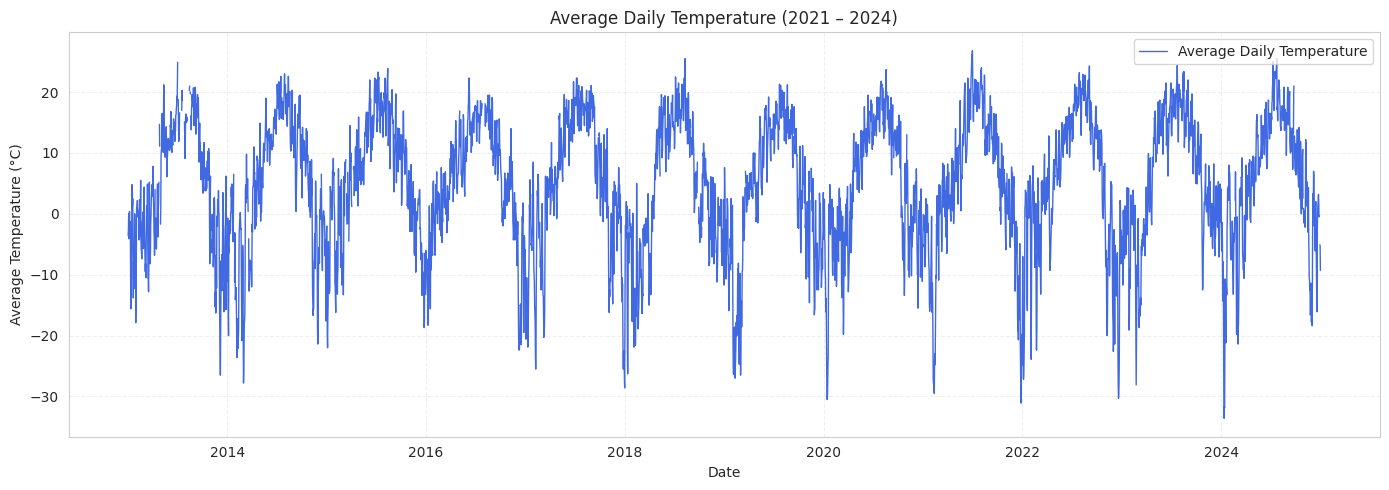

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

# -------------------------------------------------
# 1.  READ & TIDY DAILY WEATHER
# -------------------------------------------------
weather_files = sorted(glob("calgary-weather-20*.csv"))  # adjust path if needed
frames = []

for f in weather_files:
    df = pd.read_csv(f)

    # Detect the correct date column
    date_col = "Date/Time" if "Date/Time" in df.columns else "Date"
    df["date"] = pd.to_datetime(df[date_col])

    # Keep just date + mean temperature
    frames.append(
        df[["date", "Mean Temp (°C)"]]
          .rename(columns={"Mean Temp (°C)": "avg_temp_C"})
    )

# Combine all years
weather_daily = (
    pd.concat(frames, ignore_index=True)
      .sort_values("date")
      .reset_index(drop=True)
)

print(weather_daily.head())   # quick check

# -------------------------------------------------
# 2.  PLOT THE DAILY TEMPERATURE CURVE
# -------------------------------------------------
plt.figure(figsize=(14, 5))
plt.plot(weather_daily["date"],
         weather_daily["avg_temp_C"],
         color="royalblue",
         linewidth=1,
         label="Average Daily Temperature")

plt.title("Average Daily Temperature (2021 – 2024)")
plt.xlabel("Date")
plt.ylabel("Average Temperature (°C)")
plt.legend(loc="upper right")
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()


**Summary**

* Winters consistently run **6–10 pp** higher occupancy than summers.
* Temperature shows the strongest single feature (ρ ≈ ‑0.52), followed by
  snow depth and unemployment.
* Existing capacity expansions (2016 & 2020) briefly lowered utilisation,
  but levels quickly rebounded toward 85–90 %.
* Macro variables (CPI, inflation) rank lower in short‑run models but
  may carry predictive value at longer lags.

